# Hyperparameter Tuning

In this Notebook we will show how to automate the selection of optimal hyperparameters, using a [grid search](#1) of parameter configurations or a [randomised search](#2). We will also look at how to [display the results](#3) before [summarising](#4) all points.

## Load Data + Set Up

In [92]:
import pandas as pd
import seaborn as sns
import numpy as np

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

In [40]:
# load data
adult_census = pd.read_csv("datasets/adult-census.csv")

# set target
target_name = "class"

target = adult_census[target_name]
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [41]:
# split the dataset into a test and train sets
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

### Data Preprocessing

In [42]:
# selector for categorical data only
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

In [43]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

In [44]:
# preprocess categorical data, but not numerical data (no need to scale with the model we will use)
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

### Create Model for Comparison

In [51]:
%%time
# create model
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])

# fit the model
model.fit(data_train, target_train)

Wall time: 684 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [52]:
# evaluate model, but without cross-validation for simplicity
accuracy = model.score(data_test, target_test)
print(
    f"The test accuracy score of the pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the pipeline is: 0.87


In [104]:
# get a list of the models parameters (remove .keys() to also show the values)
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__cat_preprocessor', 'preprocessor__cat_preprocessor__categories', 'preprocessor__cat_preprocessor__dtype', 'preprocessor__cat_preprocessor__handle_unknown', 'preprocessor__cat_preprocessor__unknown_value', 'classifier__categorical_features', 'classifier__early_stopping', 'classifier__l2_regularization', 'classifier__learning_rate', 'classifier__loss', 'classifier__max_bins', 'classifier__max_depth', 'classifier__max_iter', 'classifier__max_leaf_nodes', 'classifier__min_samples_leaf', 'classifier__monotonic_cst', 'classifier__n_iter_no_change', 'classifier__random_state', 'classifier__scoring', 'classifier__tol', 'classifier__validation_fraction', 'classifier__verbose', 'classifier__warm

<a id="1" ></a>
## 1) GridSearchCV

In [54]:
%%time
from sklearn.model_selection import GridSearchCV

# provide a set of values to test for chosen hyperparameters
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30)}

# using the same model as before, find the best combination of provided parameters
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

Wall time: 14.8 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

In [55]:
# evaluate model, but without cross-validation for simplicity
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.88


The `GridSearchCV` estimator takes a `param_grid` parameter which defines all hyperparameters and their associated values that we want to test. The grid-search will be in charge of creating all possible combinations and test them.

The number of combinations will be equal to the product of the number of values to explore for each parameter ( 4 x 3 combinations here). Thus, adding new parameters with their associated values to be explored become rapidly __computationally expensive__.

Once the grid-search is fitted, it can be used as any other predictor by calling predict and predict_proba. __Internally, it will use the model with the best parameters found during fit__.

In [56]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


### Explore Results

In [57]:
# add results to a dataframe to examine all results
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,1.210504,0.090090,0.246707,0.003950,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.868912,0.867213,0.868063,0.000850,1
4,0.672045,0.001063,0.223092,0.007669,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,2
7,0.256112,0.002323,0.153963,0.003791,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.854826,0.862899,0.858863,0.004036,3
6,0.326341,0.093696,0.177871,0.004522,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.853844,0.860934,0.857389,0.003545,4
3,0.409324,0.006147,0.206883,0.009406,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.853781,0.853266,0.000515,5


In [60]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]

# add only the results we are interested in
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [61]:
# function to remove the headers from the parameter names
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.868063,0.000850,1
4,0.1,10,0.866425,0.000359,2
7,1,10,0.858863,0.004036,3
6,1,3,0.857389,0.003545,4
3,0.1,3,0.853266,0.000515,5
8,1,30,0.851028,0.002707,6
2,0.01,30,0.843330,0.002917,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
10,10,10,0.618080,0.124277,10


In [62]:
# as we are only looking at 2 parameters, we can visualise this as a heatmap
# first we transform the dataframe
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.843330
0.10,0.853266,0.866425,0.868063
1.00,0.857389,0.858863,0.851028
10.00,0.283476,0.618080,0.549338


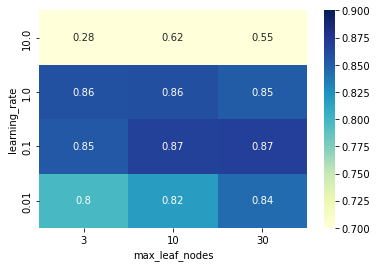

In [64]:
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The above tables highlights the following things:

- for too high values of `learning_rate`, the generalization performance of the model is degraded and adjusting the value of max_leaf_nodes cannot fix that problem;

- outside of this pathological region, we observe that the optimal choice of `max_leaf_nodes` depends on the value of learning_rate;

- in particular, we observe a “diagonal” of good models with an accuracy close to the maximal of 0.87: when the value of `max_leaf_nodes` is increased, one should decrease the value of `learning_rate` accordingly to preserve a good accuracy.

The precise meaning of those two parameters can be found here XXXXXXXX.

Note that, in general, there is __no unique optimal parameter setting__: 4 models out of the 12 parameter configurations reach the maximal accuracy (up to small random fluctuations caused by the sampling of the training set).

<a id="2" ></a>
## 2) RandomisedSearchCV

With the `GridSearchCV` estimator, the parameters need to be specified __explicitly__, and exploring a large number of values for different parameters will be quickly untractable.

Instead, we can __randomly generate the parameter candidates__. This approach __avoids the regularity of the grid__. Hence, adding more evaluations can increase the resolution in each direction. This is the case in the frequent situation where the choice of some hyperparameters is not very important, as for hyperparameter 2 in the figure below.

<div><img src="diagrams/Randomised%20Hyperparameters.jpg" width=480></div>
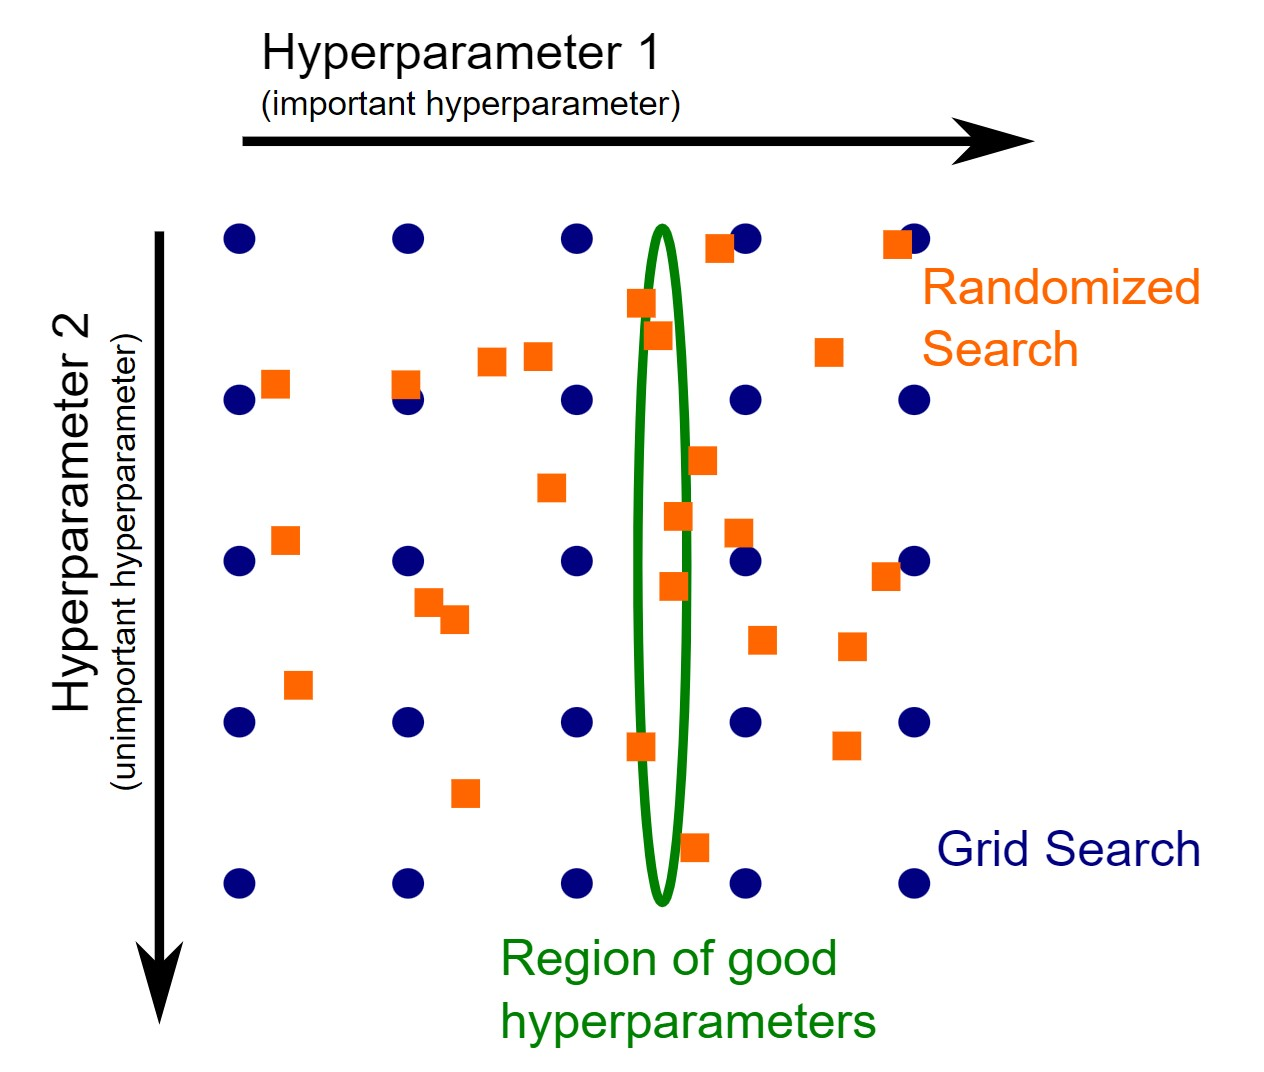

With a grid, the danger is that the region of good hyperparameters fall between the line of the grid: this region is aligned with the grid given that hyperparameter 2 has a weak influence. Rather, stochastic search will sample hyperparameter 1 independently from hyperparameter 2 and find the optimal region.

The `RandomizedSearchCV` class allows for such stochastic search. It is used similarly to the `GridSearchCV` but the sampling distributions need to be specified instead of the parameter values. Here we will draw candidates using a log-uniform distribution because the parameters we are interested in take positive values with a natural log scaling (.1 is as close to 1 as 10 is).

We will look at 5 parameters, using the same model as before:
- `l2_regularization`: the constant to regularized the loss function

- `min_samples_leaf`: the minimum number of samples required in a leaf;

- `max_bins`: the maximum number of bins to construct the histograms.

- `learning_rate`: the speed at which the gradient-boosting will correct the residuals at each boosting iteration;

- `max_leaf_nodes`: the maximum number of leaves for each tree in the ensemble.

In [65]:
# loguniform can be used to generate floating numbers
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [87]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# provide parameters to compare
param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

# using model from before
model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    cv=5, verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1min 18s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              Hi...
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021EE55B5940>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x0000021EE51AC1F0>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x0000021EE55ACFD0>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x0000021EE51AC340>},
                   verbose=1)

In [88]:
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

The test accuracy score of the best model is 0.87


In [89]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 1.3274248181267697e-05,
 'classifier__learning_rate': 0.9286290647137745,
 'classifier__max_bins': 87,
 'classifier__max_leaf_nodes': 9,
 'classifier__min_samples_leaf': 1}


In [90]:
# inspect results as before
# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
# keep only the columns we are interseted in
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

# add results to a dataframe
cv_results = pd.DataFrame(model_random_search.cv_results_)
# limit to selected columns
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)
# use the function we defined above to remove the headers from the parameter names
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
6,0.000013,0.928629,9,1,87,0.855805,0.002907,1
9,23.401205,0.055114,26,2,24,0.855669,0.003712,2
2,5.63575,1.039054,141,57,74,0.844667,0.002816,3
1,0.005933,0.207635,2,26,22,0.842893,0.002869,4
5,0.000193,0.014643,12,64,59,0.842538,0.001843,5
8,0.745006,0.046348,70,4,7,0.840518,0.003038,6
0,0.563505,0.046331,50,2,4,0.814938,0.001386,7
4,561.431746,0.187412,247,52,2,0.801752,0.003378,8
3,18.154296,0.014494,51,83,2,0.793836,0.001721,9
7,0.001263,0.001021,15,8,15,0.758947,0.000013,10


In [91]:
cv_results = cv_results.set_index("rank_test_score")
difference = cv_results["mean_test_score"][1] - cv_results["mean_test_score"][2]
triple_std = 3 * cv_results["std_test_score"][1]
print(f'The difference between the top 2 results is {difference:.4f},'
      f' and 3x the standard deviation of the top result is {triple_std:.4f}')

The difference between the top 2 results is 0.0001, and 3x the standard deviation of the top result is 0.0087


Note that we only used 10 iterations (setting `n_iter=10` in `RandomisedSearchCV`) in this example, however in practice would use many more.

<a id="3" ></a>
## 3) Interactive Exploration of Results

Here we will load results of the `RandomisedSearchCV` example above but with 200 iterations, to explore the results.

In [98]:
# load results
cv_results = pd.read_csv("figures/randomized_search_results.csv", index_col=0)

# using the function created above, remove the headers from the parameter names
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,l2_regularization,learning_rate,max_bins,max_leaf_nodes,min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.364790,0.256910,0.160201,0.027927,0.001741,0.011410,188,6,3,{'classifier__l2_regularization': 0.0017408272...,0.820527,0.815588,0.816953,0.815725,0.817363,0.817231,0.001785,65
1,1.165878,0.154081,0.156307,0.028429,0.000019,0.060289,244,3,7,{'classifier__l2_regularization': 1.9136604251...,0.835949,0.832378,0.833879,0.835244,0.837292,0.834949,0.001693,55
2,1.829658,0.135164,0.138959,0.018307,0.000004,0.001021,3,16,10,{'classifier__l2_regularization': 3.5014020335...,0.758974,0.758941,0.758941,0.758941,0.758941,0.758947,0.000013,119
3,7.492448,0.145101,0.175107,0.004313,2.283546,0.004012,149,131,3,{'classifier__l2_regularization': 2.2835460462...,0.758974,0.758941,0.758941,0.758941,0.758941,0.758947,0.000013,119
4,3.556846,0.219832,0.179252,0.021931,2.839202,0.005506,86,51,1,{'classifier__l2_regularization': 2.8392024301...,0.818070,0.811630,0.814360,0.811766,0.812312,0.813628,0.002427,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.294074,0.022162,0.131420,0.007018,0.000011,0.008725,11,10,13,{'classifier__l2_regularization': 1.1158823932...,0.789955,0.792383,0.788971,0.790609,0.793066,0.790997,0.001519,99
196,1.403853,0.056955,0.135619,0.009969,0.000001,0.007010,4,10,23,{'classifier__l2_regularization': 1.1417666366...,0.773987,0.775184,0.775594,0.774775,0.772591,0.774426,0.001060,111
197,0.869013,0.104602,0.085430,0.006067,8.910140,0.756816,61,50,75,{'classifier__l2_regularization': 8.9101403086...,0.856148,0.857494,0.858040,0.853945,0.854218,0.855969,0.001662,19
198,0.968748,0.035448,0.125690,0.006516,0.000107,0.005116,121,4,12,{'classifier__l2_regularization': 0.0001068448...,0.762386,0.762217,0.762626,0.762490,0.761671,0.762278,0.000332,117


In [99]:
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results.apply(
        {   # transformations applied to each column for readability
            "learning_rate": np.log10,
            "max_leaf_nodes": np.log2,
            "max_bins": np.log2,
            "min_samples_leaf": np.log10,
            "l2_regularization": np.log10,
            "mean_test_score": lambda x: x,
        }
    ),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

Note that we have <u>transformed most axis values by taking a log10 or log2 to spread the active ranges and improve readability</u>.

It is possible to __select a range of results by clicking and holding on any axis__ of the parallel coordinate plot. You can then slide (move) the range selection and cross two selections to see the intersections. You can undo a selection by clicking once again on the same axis.

For this hyperparameter search, it is interesting to confirm that the yellow lines (top performing models) all reach intermediate values for the `learning_rate`, that is, tick values between -2 and 0 which correspond to learning rate values of 0.01 to 1.0 once we invert back the log10 transform for that axis.

But now we can also observe that it is not possible to select the highest performing models by selecting lines of on the `max_bins` axis with tick values between 1 and 3.

The other hyperparameters are not very sensitive. We can check that if we select the `learning_rate` axis tick values between -1.5 and -0.5 and `max_bins tick` values between 5 and 8, we always select top performing models, whatever the values of the other hyperparameters.

<a id="4" ></a>
## 4) Summary

- Hyperparameters have an impact on the models’ performance and should be wisely chosen; however not all hyperparameters will have significant impact;

- The search for the best hyperparameters can be automated with a grid-search approach or a randomized search approach;

- A __grid-search__ is __expensive__ and __does not scale__ when the number of hyperparameters to optimize increase. Besides, the combination are sampled only on a regular grid.

- A __randomized-search__ allows a search with a fixed budget even with an __increasing number of hyperparameters__. Besides, the combination are sampled on a non-regular grid.